In [25]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from os import getcwd, listdir
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft,ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats

from scipy.signal import hilbert, chirp
from neurodsp.filt import filter_signal


In [4]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

In [7]:
group_data = hdf5storage.loadmat("../group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])


SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

,SubjectID,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,1,micro_m,6,4,MU,B
1,DBS3001,2,micro_c,7,1,MU,C


(229, 7)

In [12]:
def get_produced_freq():
    produced_freq = pd.read_csv('all_freq.csv', index_col='id')
    d = {'ah':0, 'oo':1, 'ee':2}
    produced_freq['stim_factor'] = produced_freq.stim.map(d)
    produced_freq['spl'] = 20*np.log10(produced_freq['rms_audio_p'])
    produced_freq = produced_freq.dropna().reset_index(drop=1)

    produced_freq['before_time'] = np.nan
    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 2:
            if produced_freq.syl_id[item-1] == 1:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]
        elif produced_freq.syl_id[item] == 3:
            if produced_freq.syl_id[item-1] == 2:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]

    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 1:
            if produced_freq.syl_id[item+1] == 2:
                if produced_freq.syl_id[item+2] == 3:
                    produced_freq.before_time[item] = (produced_freq.before_time[item+1] + 
                                                       produced_freq.before_time[item+2])/2

    produced_freq.before_time[0] = (produced_freq.before_time[1] + produced_freq.before_time[2])/2
    produced_freq = produced_freq.dropna().reset_index(drop=1)
    return produced_freq

In [13]:
def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-3.5][time_point>time_data.min()+3.5]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)
produced_df = get_produced_freq()
produced_df.shape
produced_df.head(2)

(41210, 26)

,starts,ends,duration,cons_onset,trial_id,session_id,syl_id,channel,fundamental_freq,type,...,subject,freq2,discont,contrun_id,t,t2,t3,stim_factor,spl,before_time
0,36145.009713,36145.184457,0.174745,36145.009713,1,1,1,audio_p,142.196732,vowel,...,DBS3001,20219.910530,1,1,-195.420094,38189.013071,-7.462901e+06,0,-18.178208,0.404081
1,36145.494905,36145.643055,0.148150,36145.494905,1,1,2,audio_p,140.861581,vowel,...,DBS3001,19841.984898,0,1,-194.934901,37999.615755,-7.407451e+06,1,-21.894791,0.310448


In [14]:
def get_subj_table(produced_freq, number_elec, info, timing_subj, neural_subj):
    SUBJ = info.iloc[number_elec, 0]
    SESS = info.iloc[number_elec, 1]
    subj_table = produced_freq[produced_freq.subject == SUBJ].reset_index(drop=1)
    subj_table = subj_table[subj_table.session_id == SESS].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts > timing_subj.min()+3.5].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts < timing_subj.max()-3.5].reset_index(drop=1)

        
    subj_table['avg_spike'] = np.nan
    for trial in range(subj_table.shape[0]):
        if subj_table.ends[trial] < timing_subj.max() - 3.5:
            if subj_table.starts[trial] > timing_subj.min() + 3.5:
                subj_table.avg_spike[trial] = get_avg_spike(subj_table.iloc[trial], 
                                                            neural_subj, timing_subj)
    subj_table = subj_table.dropna(0).reset_index(drop=1)
    
    subj_table['t_z'] = (subj_table['t'] - subj_table['t'].mean())/subj_table['t'].std(ddof=0)
    stim_vol_mean = subj_table['stim_volume'].mean()
    subj_table['stim_vol_z'] = (subj_table['stim_volume'] - 
                                   stim_vol_mean)/subj_table['stim_volume'].std(ddof=0)
    if subj_table['stim_volume'].unique().shape[0]==1:
        subj_table['stim_vol_z'] = 0
        

    subj_table['syl_id_z'] = (subj_table['syl_id'] - 
                              subj_table['syl_id'].mean())/subj_table['syl_id'].std(ddof=0)
    subj_table['spl_z'] = (subj_table['spl'] - 
                           subj_table['spl'].mean())/subj_table['spl'].std(ddof=0)
    stim_fac_mean = subj_table['stim_factor'].mean()
    subj_table['stim_z'] = (subj_table['stim_factor'] - 
                                   stim_fac_mean)/subj_table['stim_factor'].std(ddof=0)
    fund_freq_mean = subj_table['fundamental_freq'].mean()
    subj_table['pitch_z'] = (subj_table['fundamental_freq'] - 
                             fund_freq_mean)/subj_table['fundamental_freq'].std(ddof=0)
    subj_table['pitch_spl_z'] = subj_table['pitch_z']*subj_table['spl_z']

    return subj_table

In [15]:
def get_subj_df_cue(subject, sess, subj_table):
    cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df[cue_df['session_id']==sess].reset_index(drop=1)
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    return subj_table_cue

def find_rest_time(subject_df):
    resting_time = subject_df[subject_df['syl_id'] == 1]['starts_y'] - 1
    return resting_time

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])


In [16]:
def find_full_3_trial(subj_table):
    good_trial = []
    num_sess = len(subj_table['session_id'].unique())
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0]/num_sess == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [17]:
xvals = np.linspace(-1.5, 3.5, 5000)

In [23]:
def plot_lfp(SUBJECT, f_low, f_high):
    f_range = (f_low, f_high)
    file_path = f'../../../DBS/{SUBJECT}/Preprocessed Data/FieldTrip'
    subj_mat = hdf5storage.loadmat(f"{file_path}/{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]
    
    chanlabel = []
    for item in range(subj_mat['label'].shape[0]):
        chanlabel.append(subj_mat['label'][item][0][0][0])
    chanlabel = np.array(chanlabel)

    fs = subj_mat['fsample'][0][0]
    nChans = len(subj_mat['label'])
    nTrials = len(subj_mat['trial'][0])

    ecog_chan = []
    for item in range(nChans):
        if chanlabel[item][:4] == "ecog":
            ecog_chan.append(item)
    ecog_chan = np.array(ecog_chan)

    dbs_chan = []
    for item in range(nChans):
        if chanlabel[item][:4] == "dbs_":
            dbs_chan.append(item)
    dbs_chan = np.array(dbs_chan)

    macro_chan = []
    for item in range(nChans):
        if chanlabel[item][:5] == "macro":
            macro_chan.append(item)
    macro_chan = np.array(macro_chan)

    micro_chan = []
    for item in range(nChans):
        if chanlabel[item][:5] == "micro":
            micro_chan.append(item)
    micro_chan = np.array(micro_chan)

    time_mat = subj_mat['time'][0]
    trial_mat = subj_mat['trial'][0]

    subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
    subject_table = find_full_3_trial(subject_table).reset_index(drop=1)
    subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

    cue_df = pd.read_csv(f'../../../DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
    subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

    dbs_mat = np.zeros((subj_df_cue.shape[0], len(dbs_chan), 5000))
    macro_mat = np.zeros((subj_df_cue.shape[0], len(macro_chan), 5000))
    ecog_mat = np.zeros((subj_df_cue.shape[0], len(ecog_chan), 5000))
    micro_mat = np.zeros((subj_df_cue.shape[0], len(micro_chan), 5000))


    for item in range(subj_df_cue.shape[0]):
        time_point = subj_df_cue.iloc[item].starts_y
        for i2 in range(nTrials):
            time_min = time_mat[i2][0].min()
            time_max = time_mat[i2][0].max()
            if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
                for i3 in range(len(time_mat[i2][0])):
                    if time_mat[i2][0][i3] > time_point:
                        if len(dbs_chan)> 0:
                            sig_filt = trial_mat[i2][dbs_chan]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            dbs_mat[item] = amplitude_envelope[:, i3-1500:i3+3500]
                        if len(macro_chan)> 0:
                            sig_filt = trial_mat[i2][macro_chan]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            macro_mat[item] = amplitude_envelope[:, i3-1500:i3+3500]
                        if len(ecog_chan)> 0:
                            sig_filt = trial_mat[i2][ecog_chan]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            ecog_mat[item] = amplitude_envelope[:, i3-1500:i3+3500]
                        if len(micro_chan)> 0:
                            sig_filt = trial_mat[i2][micro_chan]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            micro_mat[item] = amplitude_envelope[:, i3-1500:i3+3500]
                        break
                        break
                        
    total_channel = 0
    total_channel += ecog_mat.shape[1]
    total_channel += dbs_mat.shape[1]
    total_channel += macro_mat.shape[1]
    total_channel += micro_mat.shape[1]
    total_channel
                        
    ncol = int(np.sqrt(total_channel))
    nrow = int(total_channel/ncol)+1

    fig, axs = plt.subplots(ncol, nrow, figsize=(nrow*1.75, ncol*1.25))
    axs = axs.flatten()
    plt.tight_layout()

    start_loc = 0
    if len(ecog_chan)> 0:
        for elec in range(ecog_mat.shape[1]):
            elec_mat = ecog_mat[:, elec]
            elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
            mean = elec_mat.mean(axis=0)
            sem = nansem(elec_mat, axis=0)
            axs[elec + start_loc].plot(xvals, mean)
            axs[elec + start_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
            axs[elec + start_loc].set(yticklabels=[], xticklabels=[], xticks=[0, 1])
            axs[elec + start_loc].text(0.5, 1, chanlabel[ecog_chan][elec], 
                                       transform=axs[elec].transAxes, fontsize=15)

    start_loc += ecog_mat.shape[1]
    if len(dbs_chan)> 0:
        for elec in range(dbs_mat.shape[1]):
            elec_mat = dbs_mat[:, elec]
            elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
            mean = elec_mat.mean(axis=0)
            sem = nansem(elec_mat, axis=0)
            axs[elec + start_loc].plot(xvals, mean)
            axs[elec + start_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
            axs[elec + start_loc].set(yticklabels=[], xticklabels=[], xticks=[0, 1])
            axs[elec + start_loc].text(0.5, 1, chanlabel[dbs_chan][elec], 
                                       transform=axs[elec + start_loc].transAxes, fontsize=15)

    start_loc += dbs_mat.shape[1]
    if len(macro_chan)> 0:
        for elec in range(macro_mat.shape[1]):
            elec_mat = macro_mat[:, elec]
            elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
            mean = elec_mat.mean(axis=0)
            sem = nansem(elec_mat, axis=0)
            axs[elec + start_loc].plot(xvals, mean)
            axs[elec + start_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
            axs[elec + start_loc].set(yticklabels=[], xticklabels=[], xticks=[0, 1])
            axs[elec + start_loc].text(0.5, 1, chanlabel[macro_chan][elec], 
                                       transform=axs[elec + start_loc].transAxes, fontsize=15)

    start_loc += macro_mat.shape[1]
    if len(micro_chan)> 0:
        for elec in range(micro_mat.shape[1]):
            elec_mat = micro_mat[:, elec]
            elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
            mean = elec_mat.mean(axis=0)
            sem = nansem(elec_mat, axis=0)
            axs[elec + start_loc].plot(xvals, mean)
            axs[elec + start_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
            axs[elec + start_loc].set(yticklabels=[], xticklabels=[], xticks=[0, 1])
            axs[elec + start_loc].text(0.5, 1, chanlabel[micro_chan][elec], 
                                       transform=axs[elec + start_loc].transAxes, fontsize=15)

    start_loc += micro_mat.shape[1]
    for i in range(start_loc, ncol*nrow):
        sns.despine(top=True, right=True, left=True, bottom=True, ax=axs[i])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    
    plt.suptitle(SUBJECT + f" LFP band {f_low}-{f_high} Hz");
    #plt.savefig(f'cue_lfp/{SUBJECT}_{f_low}-{f_high}.jpeg', dpi=200)
    #plt.close(fig);

In [21]:
dbs_subj = listdir('../../../DBS')
dbs_30s = [i for i in dbs_subj if i.startswith('DBS30')]
dbs_30s

['DBS3001',
 'DBS3003',
 'DBS3004',
 'DBS3005',
 'DBS3008',
 'DBS3010',
 'DBS3011',
 'DBS3012',
 'DBS3014',
 'DBS3015',
 'DBS3002',
 'DBS3016',
 'DBS3017',
 'DBS3018',
 'DBS3019',
 'DBS3020',
 'DBS3022',
 'DBS3021',
 'DBS3023',
 'DBS3024',
 'DBS3025',
 'DBS3026',
 'DBS3027',
 'DBS3028',
 'DBS3029',
 'DBS3030',
 'DBS3031',
 'DBS3032',
 'DBS3006']

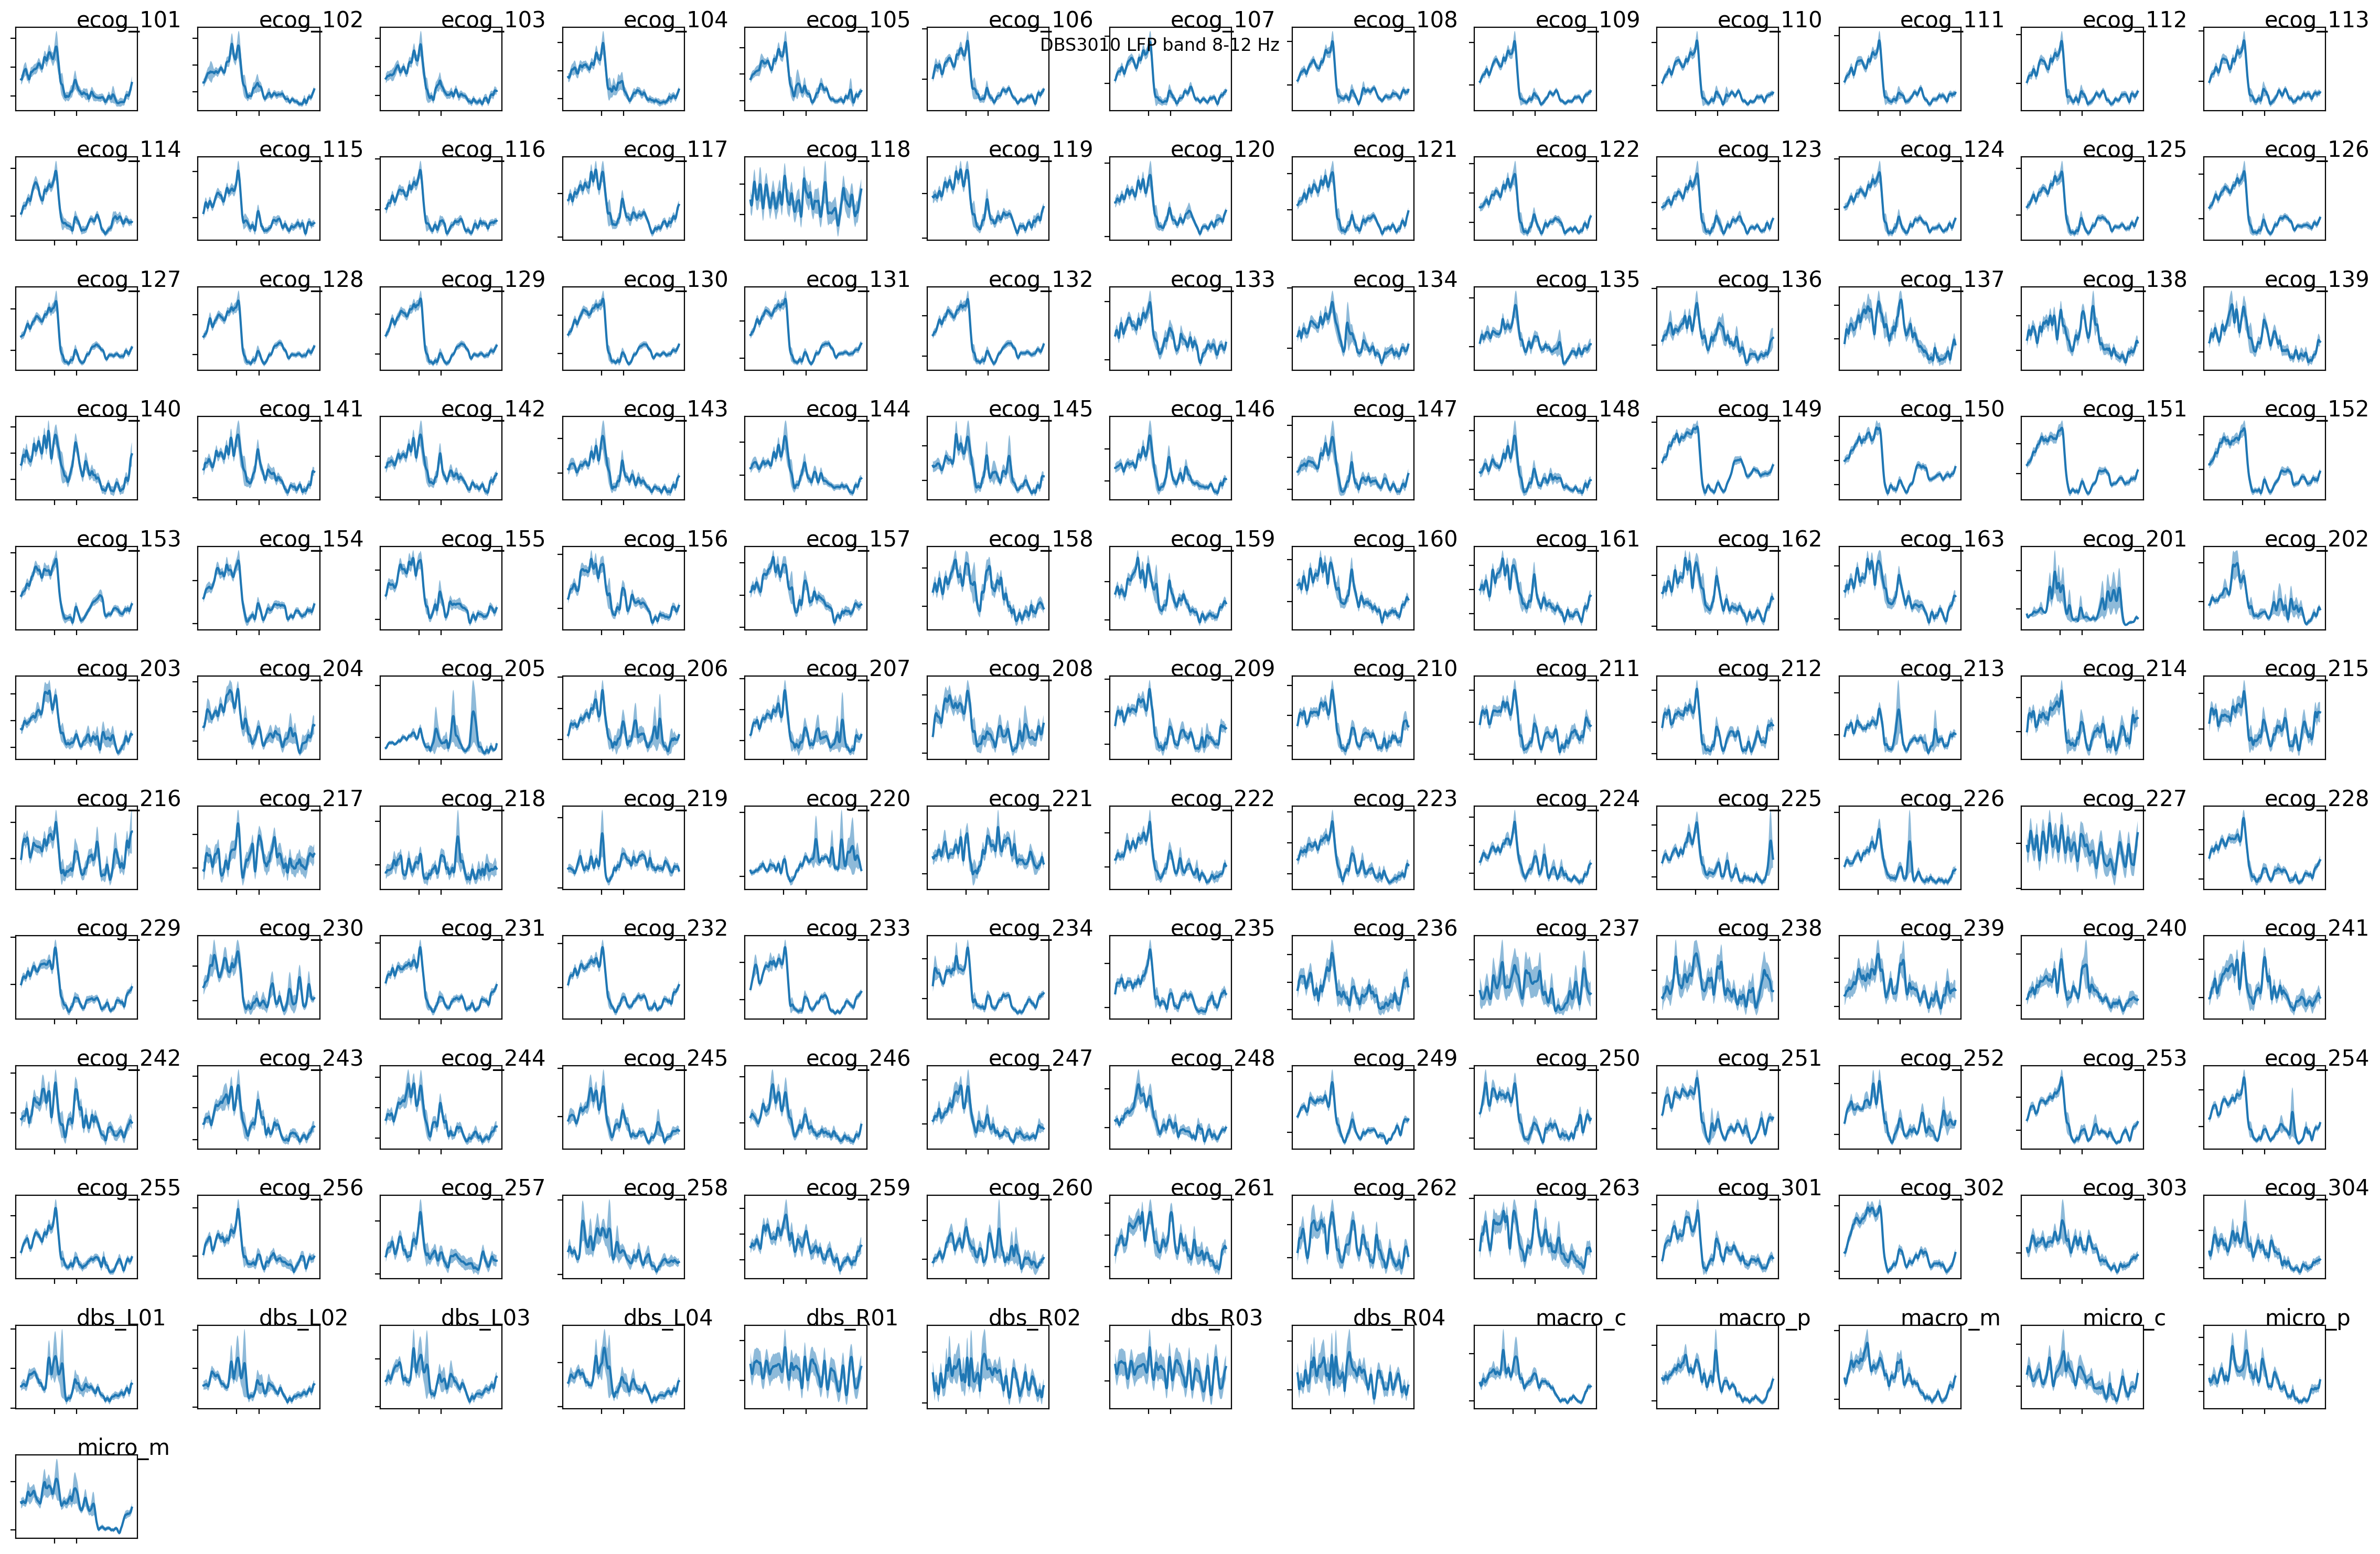

In [26]:
plot_lfp(dbs_30s[5], 8, 12)